# Miniproject 1: Image Classification

## Introduction

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://deeplearning.net/tutorial/logreg.html). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that was [recently extended](https://arxiv.org/abs/1702.05373). We break with this tradition (just a little bit) and tackle first the related problem of classifying cropped, downsampled and grayscaled images of house numbers in the [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook.

### Your names

Before you start, please enter your full name(s) in the field below; they are used to load the data. The variable student2 may remain empty, if you work alone.

In [1]:
student1 = "Lucas Gauchoux"
student2 = "Oussama Abouzaïd"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [10]:
%matplotlib inline
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam

# you may experiment with different subsets, 
# but make sure in the submission 
# it is generated with the correct random seed for all exercises.
np.random.seed(hash(student1 + student2) % 2**32)
subset_of_classes = np.random.choice(range(10), 5, replace = False)

### Plotting

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 16, ydim = 16,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


### Loading and preprocessing the data

The data consists of RGB color images with 32x32 pixels, loaded into an array of dimension 32x32x3x(number of images). We convert them to grayscale (using [this method](https://en.wikipedia.org/wiki/SRGB#The_reverse_transformation)) and we downsample them to images of 16x16 pixels by averaging over patches of 2x2 pixels.

With these preprocessing steps we obviously remove some information that could be helpful in classifying the images. But, since the processed data is much lower dimensional, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish. After having gained some experience, one may want to go back to work on the 32x32 RGB images.


In [5]:
# convert RGB images x to grayscale using the formula for Y_linear in https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale
def grayscale(x):
    x = x.astype('float32')/255
    x = np.piecewise(x, [x <= 0.04045, x > 0.04045], 
                        [lambda x: x/12.92, lambda x: ((x + .055)/1.055)**2.4])
    return .2126 * x[:,:,0,:] + .7152 * x[:,:,1,:]  + .07152 * x[:,:,2,:]

def downsample(x):
    return sum([x[i::2,j::2,:] for i in range(2) for j in range(2)])/4

def preprocess(data):
    gray = grayscale(data['X'])
    downsampled = downsample(gray)
    return (downsampled.reshape(16*16, gray.shape[2]).transpose(),
            data['y'].flatten() - 1)


data_train = scipy.io.loadmat('housenumbers/train_32x32.mat')
data_test = scipy.io.loadmat('housenumbers/test_32x32.mat')

x_train_all, y_train_all = preprocess(data_train)
x_test_all, y_test_all = preprocess(data_test)

### Selecting a subset of classes

We furter reduce the size of the dataset (and thus reduce computation time) by selecting only the 5 (out of 10 digits) in subset_of_classes.

In [6]:
def extract_classes(x, y, classes):
    indices = []
    labels = []
    count = 0
    for c in classes:
        tmp = np.where(y == c)[0]
        indices.extend(tmp)
        labels.extend(np.ones(len(tmp), dtype='uint8') * count)
        count += 1
    return x[indices], labels

x_train, y_train = extract_classes(x_train_all, y_train_all, subset_of_classes)
x_test, y_test = extract_classes(x_test_all, y_test_all, subset_of_classes)

Let us plot some examples now. The green digit at the bottom left of each image indicates the corresponding label in y_test.
For further usage of the function plot_some_samples, please have a look at its definition in the plotting section.

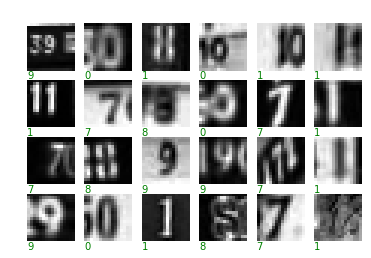

In [11]:
plot_some_samples(x_test, y_test, label_mapping = subset_of_classes);

To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing).

In [9]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

## Exercise 1: No hidden layer

### Description

Define and fit a model without a hidden layer. 

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)`


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

In [33]:
from keras.layers import Activation

In [34]:
model = Sequential([
    Dense(5, input_shape=(256,)),
    Activation("softmax"),
])

In [35]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

In [36]:
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs = 100,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 34108 samples, validate on 12117 samples
Epoch 1/100
34108/34108 [==============================] - 1s 20us/step - loss: 1.5324 - acc: 0.3975 - val_loss: 1.5161 - val_acc: 0.4188
Epoch 2/100
34108/34108 [==============================] - 0s 11us/step - loss: 1.5152 - acc: 0.4064 - val_loss: 1.5032 - val_acc: 0.4207
Epoch 3/100
34108/34108 [==============================] - 0s 11us/step - loss: 1.5060 - acc: 0.4066 - val_loss: 1.4939 - val_acc: 0.4210
Epoch 4/100
34108/34108 [==============================] - 0s 10us/step - loss: 1.4999 - acc: 0.4066 - val_loss: 1.4882 - val_acc: 0.4216
Epoch 5/100
34108/34108 [==============================] - 0s 9us/step - loss: 1.4955 - acc: 0.4067 - val_loss: 1.4850 - val_acc: 0.4219
Epoch 6/100
34108/34108 [==============================] - 0s 9us/step - loss: 1.4924 - acc: 0.4067 - val_loss: 1.4816 - val_acc: 0.4221
Epoch 7/100
34108/34108 [==============================] - 0s 9us/step - loss: 1.4898 - acc: 0.4069 - val_loss: 1.4791 - val

Epoch 60/100
34108/34108 [==============================] - 0s 9us/step - loss: 1.4551 - acc: 0.4209 - val_loss: 1.4631 - val_acc: 0.4400
Epoch 61/100
34108/34108 [==============================] - 0s 8us/step - loss: 1.4549 - acc: 0.4211 - val_loss: 1.4633 - val_acc: 0.4416
Epoch 62/100
34108/34108 [==============================] - 0s 8us/step - loss: 1.4545 - acc: 0.4218 - val_loss: 1.4626 - val_acc: 0.4391
Epoch 63/100
34108/34108 [==============================] - 0s 8us/step - loss: 1.4543 - acc: 0.4216 - val_loss: 1.4626 - val_acc: 0.4396
Epoch 64/100
34108/34108 [==============================] - 0s 8us/step - loss: 1.4540 - acc: 0.4219 - val_loss: 1.4629 - val_acc: 0.4404
Epoch 65/100
34108/34108 [==============================] - 0s 8us/step - loss: 1.4538 - acc: 0.4222 - val_loss: 1.4627 - val_acc: 0.4411
Epoch 66/100
34108/34108 [==============================] - 0s 8us/step - loss: 1.4535 - acc: 0.4223 - val_loss: 1.4629 - val_acc: 0.4409
Epoch 67/100
34108/34108 [========

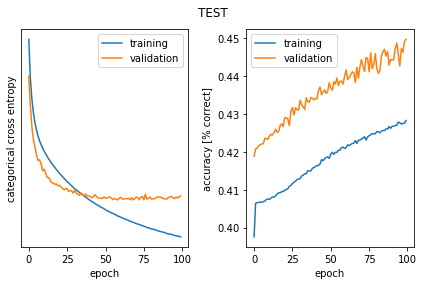

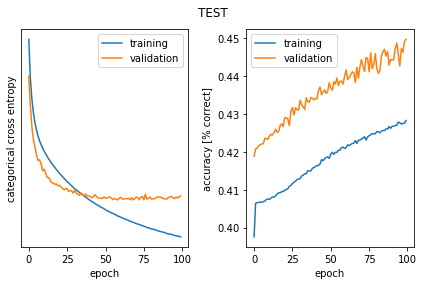

In [38]:
plot_history(history,"TEST")

## Exercise 2: One hidden layer, different optizimizers
### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 64 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to inspect your model.
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent and answer the question below.
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam).
4. Plot the learning curves of SGD with a reasonable learning rate together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.

### Solution

In [95]:
model_2 = Sequential([
    Dense(64, input_shape=(256,)),
    Activation('relu'),
    Dense(5),
    Activation('softmax'),
])
#model_2.add(Dense(64, input_shape=(256,), activation = 'relu'))
#model_2.add(Dense(5, activation = 'relu'))

In [96]:
model_2.compile(loss="categorical_crossentropy",
              optimizer=SGD(),
              metrics=['accuracy'])

In [97]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 64)                16448     
_________________________________________________________________
activation_13 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 5)                 325       
_________________________________________________________________
activation_14 (Activation)   (None, 5)                 0         
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


In [101]:
history = model_2.fit(x_train, y_train,
           batch_size= 128,
           epochs=50,
           verbose=1,
           validation_data=(x_test, y_test))

Train on 34108 samples, validate on 12117 samples
Epoch 1/50
34108/34108 [==============================] - 0s 14us/step - loss: 0.5333 - acc: 0.8404 - val_loss: 0.6124 - val_acc: 0.8180
Epoch 2/50
34108/34108 [==============================] - 0s 14us/step - loss: 0.5326 - acc: 0.8409 - val_loss: 0.6112 - val_acc: 0.8186
Epoch 3/50
34108/34108 [==============================] - 0s 14us/step - loss: 0.5319 - acc: 0.8405 - val_loss: 0.6111 - val_acc: 0.8198
Epoch 4/50
34108/34108 [==============================] - 0s 13us/step - loss: 0.5309 - acc: 0.8413 - val_loss: 0.6114 - val_acc: 0.8182
Epoch 5/50
34108/34108 [==============================] - 0s 13us/step - loss: 0.5300 - acc: 0.8419 - val_loss: 0.6098 - val_acc: 0.8191
Epoch 6/50
34108/34108 [==============================] - 0s 12us/step - loss: 0.5293 - acc: 0.8419 - val_loss: 0.6128 - val_acc: 0.8187
Epoch 7/50
34108/34108 [==============================] - 0s 12us/step - loss: 0.5282 - acc: 0.8415 - val_loss: 0.6112 - val_acc

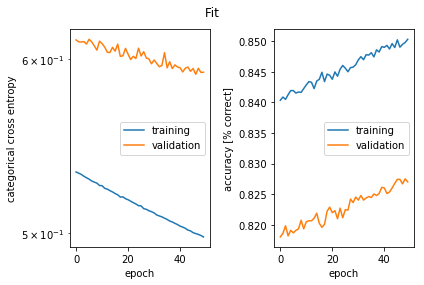

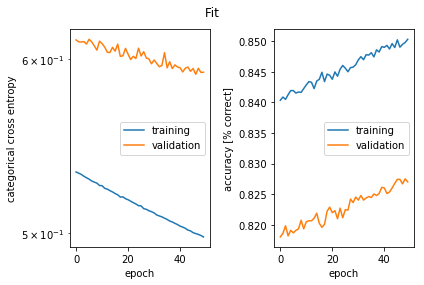

In [102]:
plot_history(history, "Fit")

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence (double click this markdown cell to edit).

**Answer**:

A) 

B) 

## Exercise 3: Overfitting and early stopping with Adam

### Description

Run the above simulation with Adam for sufficiently many epochs (be patient!) until you see clear overfitting.

1. Plot the learning curves of a fit with Adam and sufficiently many epochs and answer the questions below.

A simple, but effective mean to avoid overfitting is early stopping, i.e. a fit is not run until convergence but stopped as soon as the validation error starts to increase. We will use early stopping in all subsequent exercises.

### Solution

In [103]:
model_2.compile(loss="categorical_crossentropy",
              optimizer=Adam(),
              metrics=['accuracy'])

In [104]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 64)                16448     
_________________________________________________________________
activation_13 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 5)                 325       
_________________________________________________________________
activation_14 (Activation)   (None, 5)                 0         
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


In [105]:
history = model_2.fit(x_train, y_train,
           batch_size= 128,
           epochs=1000,
           verbose=1,
           validation_data=(x_test, y_test))

Train on 34108 samples, validate on 12117 samples
Epoch 1/1000
34108/34108 [==============================] - 1s 24us/step - loss: 0.5169 - acc: 0.8434 - val_loss: 0.6026 - val_acc: 0.8239
Epoch 2/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.5079 - acc: 0.8454 - val_loss: 0.5957 - val_acc: 0.8213
Epoch 3/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.5040 - acc: 0.8465 - val_loss: 0.5854 - val_acc: 0.8288
Epoch 4/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.4940 - acc: 0.8510 - val_loss: 0.5708 - val_acc: 0.8324
Epoch 5/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.4878 - acc: 0.8532 - val_loss: 0.5886 - val_acc: 0.8292
Epoch 6/1000
34108/34108 [==============================] - 0s 12us/step - loss: 0.4790 - acc: 0.8544 - val_loss: 0.5763 - val_acc: 0.8354
Epoch 7/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.4753 - acc: 0.8557 - val_loss: 0.

34108/34108 [==============================] - 0s 13us/step - loss: 0.3046 - acc: 0.9093 - val_loss: 0.4878 - val_acc: 0.8768
Epoch 60/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.3010 - acc: 0.9103 - val_loss: 0.4913 - val_acc: 0.8736
Epoch 61/1000
34108/34108 [==============================] - 0s 12us/step - loss: 0.3016 - acc: 0.9105 - val_loss: 0.5087 - val_acc: 0.8705
Epoch 62/1000
34108/34108 [==============================] - 0s 12us/step - loss: 0.3001 - acc: 0.9092 - val_loss: 0.4906 - val_acc: 0.8751
Epoch 63/1000
34108/34108 [==============================] - 0s 11us/step - loss: 0.2980 - acc: 0.9111 - val_loss: 0.4968 - val_acc: 0.8719
Epoch 64/1000
34108/34108 [==============================] - 0s 12us/step - loss: 0.2951 - acc: 0.9114 - val_loss: 0.4936 - val_acc: 0.8751
Epoch 65/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.2943 - acc: 0.9113 - val_loss: 0.4932 - val_acc: 0.8746
Epoch 66/1000
34108/34108 [=======

34108/34108 [==============================] - 0s 13us/step - loss: 0.2378 - acc: 0.9274 - val_loss: 0.5153 - val_acc: 0.8809
Epoch 118/1000
34108/34108 [==============================] - 0s 12us/step - loss: 0.2421 - acc: 0.9272 - val_loss: 0.5030 - val_acc: 0.8825
Epoch 119/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.2383 - acc: 0.9288 - val_loss: 0.5172 - val_acc: 0.8803
Epoch 120/1000
34108/34108 [==============================] - 0s 12us/step - loss: 0.2389 - acc: 0.9276 - val_loss: 0.5213 - val_acc: 0.8769
Epoch 121/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.2391 - acc: 0.9270 - val_loss: 0.5248 - val_acc: 0.8765
Epoch 122/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.2377 - acc: 0.9280 - val_loss: 0.5249 - val_acc: 0.8815
Epoch 123/1000
34108/34108 [==============================] - 0s 12us/step - loss: 0.2393 - acc: 0.9280 - val_loss: 0.5235 - val_acc: 0.8788
Epoch 124/1000
34108/34108 [

34108/34108 [==============================] - 0s 12us/step - loss: 0.2048 - acc: 0.9377 - val_loss: 0.5487 - val_acc: 0.8789
Epoch 176/1000
34108/34108 [==============================] - 0s 12us/step - loss: 0.2042 - acc: 0.9378 - val_loss: 0.5546 - val_acc: 0.8776
Epoch 177/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.2052 - acc: 0.9378 - val_loss: 0.5548 - val_acc: 0.8792
Epoch 178/1000
34108/34108 [==============================] - 0s 12us/step - loss: 0.2070 - acc: 0.9373 - val_loss: 0.5455 - val_acc: 0.8826
Epoch 179/1000
34108/34108 [==============================] - 0s 12us/step - loss: 0.2070 - acc: 0.9365 - val_loss: 0.5604 - val_acc: 0.8763
Epoch 180/1000
34108/34108 [==============================] - 0s 11us/step - loss: 0.2022 - acc: 0.9392 - val_loss: 0.5437 - val_acc: 0.8803
Epoch 181/1000
34108/34108 [==============================] - 0s 12us/step - loss: 0.2047 - acc: 0.9374 - val_loss: 0.5542 - val_acc: 0.8807
Epoch 182/1000
34108/34108 [

34108/34108 [==============================] - 0s 13us/step - loss: 0.1836 - acc: 0.9422 - val_loss: 0.5781 - val_acc: 0.8793
Epoch 234/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.1843 - acc: 0.9436 - val_loss: 0.5919 - val_acc: 0.8777
Epoch 235/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.1816 - acc: 0.9442 - val_loss: 0.5889 - val_acc: 0.8782
Epoch 236/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.1790 - acc: 0.9449 - val_loss: 0.5887 - val_acc: 0.8798
Epoch 237/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.1840 - acc: 0.9440 - val_loss: 0.5744 - val_acc: 0.8812
Epoch 238/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.1787 - acc: 0.9447 - val_loss: 0.6086 - val_acc: 0.8759
Epoch 239/1000
34108/34108 [==============================] - 0s 12us/step - loss: 0.1806 - acc: 0.9442 - val_loss: 0.5810 - val_acc: 0.8816
Epoch 240/1000
34108/34108 [

34108/34108 [==============================] - 1s 15us/step - loss: 0.1667 - acc: 0.9476 - val_loss: 0.6235 - val_acc: 0.8787
Epoch 292/1000
34108/34108 [==============================] - 0s 14us/step - loss: 0.1634 - acc: 0.9496 - val_loss: 0.6206 - val_acc: 0.8793
Epoch 293/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.1649 - acc: 0.9496 - val_loss: 0.6235 - val_acc: 0.8779
Epoch 294/1000
34108/34108 [==============================] - 0s 15us/step - loss: 0.1690 - acc: 0.9470 - val_loss: 0.6169 - val_acc: 0.8783
Epoch 295/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.1649 - acc: 0.9499 - val_loss: 0.6336 - val_acc: 0.8778
Epoch 296/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.1663 - acc: 0.9485 - val_loss: 0.6185 - val_acc: 0.8829
Epoch 297/1000
34108/34108 [==============================] - 0s 14us/step - loss: 0.1619 - acc: 0.9498 - val_loss: 0.6173 - val_acc: 0.8807
Epoch 298/1000
34108/34108 [

34108/34108 [==============================] - 0s 12us/step - loss: 0.1526 - acc: 0.9530 - val_loss: 0.6531 - val_acc: 0.8787
Epoch 350/1000
34108/34108 [==============================] - 0s 12us/step - loss: 0.1503 - acc: 0.9540 - val_loss: 0.6485 - val_acc: 0.8787
Epoch 351/1000
34108/34108 [==============================] - 0s 12us/step - loss: 0.1528 - acc: 0.9539 - val_loss: 0.6648 - val_acc: 0.8744
Epoch 352/1000
34108/34108 [==============================] - 0s 12us/step - loss: 0.1512 - acc: 0.9534 - val_loss: 0.6685 - val_acc: 0.8743
Epoch 353/1000
34108/34108 [==============================] - ETA: 0s - loss: 0.1546 - acc: 0.951 - 0s 12us/step - loss: 0.1547 - acc: 0.9507 - val_loss: 0.6685 - val_acc: 0.8737
Epoch 354/1000
34108/34108 [==============================] - 0s 12us/step - loss: 0.1516 - acc: 0.9526 - val_loss: 0.6651 - val_acc: 0.8778
Epoch 355/1000
34108/34108 [==============================] - 0s 12us/step - loss: 0.1558 - acc: 0.9515 - val_loss: 0.6480 - val_ac

Epoch 407/1000
34108/34108 [==============================] - 0s 12us/step - loss: 0.1410 - acc: 0.9567 - val_loss: 0.6913 - val_acc: 0.8744
Epoch 408/1000
34108/34108 [==============================] - 0s 12us/step - loss: 0.1384 - acc: 0.9575 - val_loss: 0.6791 - val_acc: 0.8773
Epoch 409/1000
34108/34108 [==============================] - 0s 12us/step - loss: 0.1481 - acc: 0.9541 - val_loss: 0.6921 - val_acc: 0.8741
Epoch 410/1000
34108/34108 [==============================] - 0s 12us/step - loss: 0.1407 - acc: 0.9565 - val_loss: 0.6740 - val_acc: 0.8806
Epoch 411/1000
34108/34108 [==============================] - 0s 12us/step - loss: 0.1408 - acc: 0.9564 - val_loss: 0.6770 - val_acc: 0.8807
Epoch 412/1000
34108/34108 [==============================] - 0s 12us/step - loss: 0.1394 - acc: 0.9573 - val_loss: 0.6805 - val_acc: 0.8785
Epoch 413/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.1450 - acc: 0.9550 - val_loss: 0.6844 - val_acc: 0.8780
Epoch 414/100

Epoch 465/1000
34108/34108 [==============================] - 0s 14us/step - loss: 0.1313 - acc: 0.9595 - val_loss: 0.7222 - val_acc: 0.8742
Epoch 466/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.1340 - acc: 0.9588 - val_loss: 0.7174 - val_acc: 0.8730
Epoch 467/1000
34108/34108 [==============================] - 0s 14us/step - loss: 0.1312 - acc: 0.9592 - val_loss: 0.7008 - val_acc: 0.8777
Epoch 468/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.1360 - acc: 0.9575 - val_loss: 0.7084 - val_acc: 0.8765
Epoch 469/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.1321 - acc: 0.9587 - val_loss: 0.7052 - val_acc: 0.8797
Epoch 470/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.1305 - acc: 0.9598 - val_loss: 0.7106 - val_acc: 0.8788
Epoch 471/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.1349 - acc: 0.9569 - val_loss: 0.7118 - val_acc: 0.8779
Epoch 472/100

34108/34108 [==============================] - 0s 14us/step - loss: 0.1275 - acc: 0.9611 - val_loss: 0.7395 - val_acc: 0.8748
Epoch 524/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.1228 - acc: 0.9622 - val_loss: 0.7598 - val_acc: 0.8697
Epoch 525/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.1238 - acc: 0.9622 - val_loss: 0.7301 - val_acc: 0.8787
Epoch 526/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.1222 - acc: 0.9620 - val_loss: 0.7258 - val_acc: 0.8791
Epoch 527/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.1243 - acc: 0.9622 - val_loss: 0.7396 - val_acc: 0.8765
Epoch 528/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.1293 - acc: 0.9605 - val_loss: 0.7178 - val_acc: 0.8803
Epoch 529/1000
34108/34108 [==============================] - 0s 14us/step - loss: 0.1196 - acc: 0.9633 - val_loss: 0.7232 - val_acc: 0.8789
Epoch 530/1000
34108/34108 [

34108/34108 [==============================] - 1s 15us/step - loss: 0.1201 - acc: 0.9629 - val_loss: 0.7554 - val_acc: 0.8760
Epoch 582/1000
34108/34108 [==============================] - 1s 17us/step - loss: 0.1230 - acc: 0.9619 - val_loss: 0.7467 - val_acc: 0.8782
Epoch 583/1000
34108/34108 [==============================] - 1s 16us/step - loss: 0.1180 - acc: 0.9648 - val_loss: 0.7505 - val_acc: 0.8786
Epoch 584/1000
34108/34108 [==============================] - 1s 17us/step - loss: 0.1139 - acc: 0.9646 - val_loss: 0.7971 - val_acc: 0.8663
Epoch 585/1000
34108/34108 [==============================] - 1s 16us/step - loss: 0.1184 - acc: 0.9638 - val_loss: 0.7604 - val_acc: 0.8780
Epoch 586/1000
34108/34108 [==============================] - 1s 16us/step - loss: 0.1192 - acc: 0.9636 - val_loss: 0.7463 - val_acc: 0.8779
Epoch 587/1000
34108/34108 [==============================] - 1s 16us/step - loss: 0.1200 - acc: 0.9633 - val_loss: 0.7541 - val_acc: 0.8763
Epoch 588/1000
34108/34108 [

Epoch 639/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.1137 - acc: 0.9653 - val_loss: 0.7933 - val_acc: 0.8752
Epoch 640/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.1149 - acc: 0.9645 - val_loss: 0.7814 - val_acc: 0.8773
Epoch 641/1000
34108/34108 [==============================] - 0s 14us/step - loss: 0.1116 - acc: 0.9668 - val_loss: 0.7679 - val_acc: 0.8779
Epoch 642/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.1137 - acc: 0.9644 - val_loss: 0.8010 - val_acc: 0.8707
Epoch 643/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.1117 - acc: 0.9652 - val_loss: 0.7747 - val_acc: 0.8769
Epoch 644/1000
34108/34108 [==============================] - 0s 14us/step - loss: 0.1144 - acc: 0.9651 - val_loss: 0.7758 - val_acc: 0.8764
Epoch 645/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.1151 - acc: 0.9647 - val_loss: 0.7725 - val_acc: 0.8775
Epoch 646/100

34108/34108 [==============================] - 0s 11us/step - loss: 0.1077 - acc: 0.9661 - val_loss: 0.8067 - val_acc: 0.8722
Epoch 698/1000
34108/34108 [==============================] - 0s 12us/step - loss: 0.1108 - acc: 0.9651 - val_loss: 0.7922 - val_acc: 0.8770
Epoch 699/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.1106 - acc: 0.9663 - val_loss: 0.8051 - val_acc: 0.8765
Epoch 700/1000
34108/34108 [==============================] - 0s 14us/step - loss: 0.1078 - acc: 0.9664 - val_loss: 0.8104 - val_acc: 0.8771
Epoch 701/1000
34108/34108 [==============================] - 0s 11us/step - loss: 0.1064 - acc: 0.9669 - val_loss: 0.7841 - val_acc: 0.8797
Epoch 702/1000
34108/34108 [==============================] - 0s 12us/step - loss: 0.1106 - acc: 0.9657 - val_loss: 0.8012 - val_acc: 0.8746
Epoch 703/1000
34108/34108 [==============================] - 0s 12us/step - loss: 0.1089 - acc: 0.9665 - val_loss: 0.7946 - val_acc: 0.8776
Epoch 704/1000
34108/34108 [

34108/34108 [==============================] - 0s 13us/step - loss: 0.1079 - acc: 0.9667 - val_loss: 0.8102 - val_acc: 0.8756
Epoch 756/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.1030 - acc: 0.9686 - val_loss: 0.8395 - val_acc: 0.8725
Epoch 757/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.1029 - acc: 0.9684 - val_loss: 0.8329 - val_acc: 0.8738
Epoch 758/1000
34108/34108 [==============================] - 0s 11us/step - loss: 0.1056 - acc: 0.9675 - val_loss: 0.8066 - val_acc: 0.8784
Epoch 759/1000
34108/34108 [==============================] - 1s 16us/step - loss: 0.0999 - acc: 0.9703 - val_loss: 0.8127 - val_acc: 0.8765
Epoch 760/1000
34108/34108 [==============================] - 0s 14us/step - loss: 0.1037 - acc: 0.9685 - val_loss: 0.8453 - val_acc: 0.8725
Epoch 761/1000
34108/34108 [==============================] - 1s 15us/step - loss: 0.1104 - acc: 0.9644 - val_loss: 0.8377 - val_acc: 0.8721
Epoch 762/1000
34108/34108 [

34108/34108 [==============================] - 0s 13us/step - loss: 0.0974 - acc: 0.9706 - val_loss: 0.8411 - val_acc: 0.8736
Epoch 814/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.0992 - acc: 0.9699 - val_loss: 0.8462 - val_acc: 0.8744
Epoch 815/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.1009 - acc: 0.9695 - val_loss: 0.8430 - val_acc: 0.8749
Epoch 816/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.1045 - acc: 0.9670 - val_loss: 0.8346 - val_acc: 0.8769
Epoch 817/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.0957 - acc: 0.9709 - val_loss: 0.8466 - val_acc: 0.8743
Epoch 818/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.0965 - acc: 0.9697 - val_loss: 0.8383 - val_acc: 0.8756
Epoch 819/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.1000 - acc: 0.9702 - val_loss: 0.8420 - val_acc: 0.8751
Epoch 820/1000
34108/34108 [

34108/34108 [==============================] - 0s 14us/step - loss: 0.0935 - acc: 0.9726 - val_loss: 0.8728 - val_acc: 0.8727
Epoch 872/1000
34108/34108 [==============================] - 0s 15us/step - loss: 0.0936 - acc: 0.9712 - val_loss: 0.8458 - val_acc: 0.8769
Epoch 873/1000
34108/34108 [==============================] - 0s 14us/step - loss: 0.0982 - acc: 0.9695 - val_loss: 0.8762 - val_acc: 0.8727
Epoch 874/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.1067 - acc: 0.9655 - val_loss: 0.8434 - val_acc: 0.8775
Epoch 875/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.0939 - acc: 0.9712 - val_loss: 0.8437 - val_acc: 0.8759
Epoch 876/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.0987 - acc: 0.9691 - val_loss: 0.8541 - val_acc: 0.8754
Epoch 877/1000
34108/34108 [==============================] - 0s 13us/step - loss: 0.0945 - acc: 0.9710 - val_loss: 0.8558 - val_acc: 0.8752
Epoch 878/1000
34108/34108 [

34108/34108 [==============================] - 0s 11us/step - loss: 0.0937 - acc: 0.9715 - val_loss: 0.8856 - val_acc: 0.8724
Epoch 930/1000
34108/34108 [==============================] - 0s 12us/step - loss: 0.0930 - acc: 0.9717 - val_loss: 0.8755 - val_acc: 0.8759
Epoch 931/1000
34108/34108 [==============================] - 0s 11us/step - loss: 0.0895 - acc: 0.9731 - val_loss: 0.9026 - val_acc: 0.8694
Epoch 932/1000
34108/34108 [==============================] - 0s 12us/step - loss: 0.0993 - acc: 0.9692 - val_loss: 0.8742 - val_acc: 0.8743
Epoch 933/1000
34108/34108 [==============================] - 0s 11us/step - loss: 0.0900 - acc: 0.9727 - val_loss: 0.8649 - val_acc: 0.8771
Epoch 934/1000
34108/34108 [==============================] - 0s 11us/step - loss: 0.0873 - acc: 0.9742 - val_loss: 0.8594 - val_acc: 0.8772
Epoch 935/1000
34108/34108 [==============================] - 0s 11us/step - loss: 0.0941 - acc: 0.9712 - val_loss: 0.8735 - val_acc: 0.8760
Epoch 936/1000
34108/34108 [

34108/34108 [==============================] - 0s 13us/step - loss: 0.0875 - acc: 0.9735 - val_loss: 0.8959 - val_acc: 0.8733
Epoch 988/1000
34108/34108 [==============================] - 0s 12us/step - loss: 0.0925 - acc: 0.9717 - val_loss: 0.9029 - val_acc: 0.8710
Epoch 989/1000
34108/34108 [==============================] - 0s 11us/step - loss: 0.0867 - acc: 0.9744 - val_loss: 0.9088 - val_acc: 0.8706
Epoch 990/1000
34108/34108 [==============================] - 0s 11us/step - loss: 0.0896 - acc: 0.9724 - val_loss: 0.9095 - val_acc: 0.8728
Epoch 991/1000
34108/34108 [==============================] - 0s 12us/step - loss: 0.0883 - acc: 0.9733 - val_loss: 0.8926 - val_acc: 0.8750
Epoch 992/1000
34108/34108 [==============================] - 0s 12us/step - loss: 0.0877 - acc: 0.9737 - val_loss: 0.9008 - val_acc: 0.8729
Epoch 993/1000
34108/34108 [==============================] - 0s 12us/step - loss: 0.0868 - acc: 0.9738 - val_loss: 0.9074 - val_acc: 0.8736
Epoch 994/1000
34108/34108 [

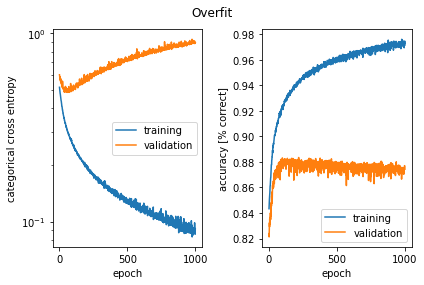

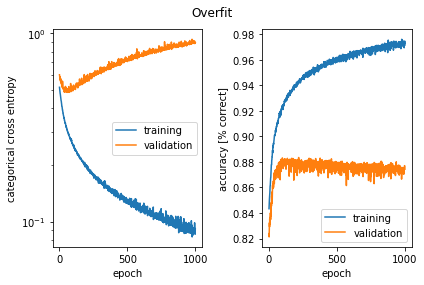

In [106]:
plot_history(history,"Overfit")

**Question 1**: At which epoch (approximately) does the model start to overfit? Please answer with one full sentence.

**Answer**: 

**Question 2**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: 

## Exercise 4: Model performance as a function of number of hidden neurons

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models with different hidden layer size (between 10 and 1000 hidden neurons) for a fixed number of epochs well beyond the point of overfitting.
2. Collect some statistics by fitting the same models as in 1. for multiple initial conditions. Hints: 1. If you don't reset the random seed, you get different initial conditions each time you create a new model. 2. Let your computer work while you are asleep.
3. Plot summary statistics of the final validation loss and accuracy versus the number of hidden neurons. Hint: [boxplots](https://matplotlib.org/examples/pylab_examples/boxplot_demo.html) (also [here](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot)) are useful. You may also want to use the matplotlib method set_xticklabels.
4. Plot summary statistics of the loss and accuracy for early stopping versus the number of hidden neurons.

### Solution

In [108]:
nb_neurones =[10,100,200,400,600,750,1000]
models = []
models_history = []
for i, nb in enumerate(nb_neurones):
    tmp = Sequential([
        Dense(nb, input_shape=(256,), activation='relu'),
        Dense(5, activation='softmax')
    ])
    tmp.compile(loss= "categorical_crossentropy",
               optimizer = Adam(),
               metrics=['accuracy'])
    models.append(tmp)
    history = tmp.fit(x_train, y_train,
           batch_size= 128,
           epochs=500,
           verbose=1,
           validation_data=(x_test, y_test))
    models_history.append(history)

Train on 34108 samples, validate on 12117 samples
Epoch 1/500
34108/34108 [==============================] - 1s 23us/step - loss: 1.5049 - acc: 0.4036 - val_loss: 1.4223 - val_acc: 0.4348
Epoch 2/500
34108/34108 [==============================] - 0s 11us/step - loss: 1.3788 - acc: 0.4442 - val_loss: 1.2664 - val_acc: 0.4990
Epoch 3/500
34108/34108 [==============================] - 0s 11us/step - loss: 1.2497 - acc: 0.5025 - val_loss: 1.1573 - val_acc: 0.5651
Epoch 4/500
34108/34108 [==============================] - 0s 11us/step - loss: 1.1517 - acc: 0.5508 - val_loss: 1.0809 - val_acc: 0.5942
Epoch 5/500
34108/34108 [==============================] - 0s 11us/step - loss: 1.0852 - acc: 0.5938 - val_loss: 1.0438 - val_acc: 0.6227
Epoch 6/500
34108/34108 [==============================] - 0s 11us/step - loss: 1.0363 - acc: 0.6196 - val_loss: 1.0076 - val_acc: 0.6502
Epoch 7/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.9994 - acc: 0.6384 - val_loss: 0.9757 - 

34108/34108 [==============================] - 0s 10us/step - loss: 0.7385 - acc: 0.7664 - val_loss: 0.8248 - val_acc: 0.7461
Epoch 60/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.7366 - acc: 0.7648 - val_loss: 0.8178 - val_acc: 0.7484
Epoch 61/500
34108/34108 [==============================] - 0s 10us/step - loss: 0.7350 - acc: 0.7661 - val_loss: 0.8276 - val_acc: 0.7436
Epoch 62/500
34108/34108 [==============================] - 0s 10us/step - loss: 0.7353 - acc: 0.7670 - val_loss: 0.8253 - val_acc: 0.7466
Epoch 63/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.7331 - acc: 0.7675 - val_loss: 0.8201 - val_acc: 0.7453
Epoch 64/500
34108/34108 [==============================] - 0s 10us/step - loss: 0.7320 - acc: 0.7676 - val_loss: 0.8193 - val_acc: 0.7477
Epoch 65/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.7318 - acc: 0.7686 - val_loss: 0.8138 - val_acc: 0.7484
Epoch 66/500
34108/34108 [==============

Epoch 118/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.6948 - acc: 0.7801 - val_loss: 0.8064 - val_acc: 0.7584
Epoch 119/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.6957 - acc: 0.7793 - val_loss: 0.8029 - val_acc: 0.7573
Epoch 120/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.6962 - acc: 0.7798 - val_loss: 0.7946 - val_acc: 0.7611
Epoch 121/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.6946 - acc: 0.7795 - val_loss: 0.8011 - val_acc: 0.7593
Epoch 122/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.6937 - acc: 0.7806 - val_loss: 0.8091 - val_acc: 0.7554
Epoch 123/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.6950 - acc: 0.7804 - val_loss: 0.8055 - val_acc: 0.7584
Epoch 124/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.6924 - acc: 0.7806 - val_loss: 0.7981 - val_acc: 0.7589
Epoch 125/500
34108/

34108/34108 [==============================] - 0s 11us/step - loss: 0.6788 - acc: 0.7848 - val_loss: 0.8079 - val_acc: 0.7603
Epoch 177/500
34108/34108 [==============================] - 0s 10us/step - loss: 0.6770 - acc: 0.7848 - val_loss: 0.8049 - val_acc: 0.7585
Epoch 178/500
34108/34108 [==============================] - 0s 10us/step - loss: 0.6789 - acc: 0.7844 - val_loss: 0.8058 - val_acc: 0.7621
Epoch 179/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.6776 - acc: 0.7840 - val_loss: 0.8078 - val_acc: 0.7601
Epoch 180/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.6782 - acc: 0.7841 - val_loss: 0.8058 - val_acc: 0.7560
Epoch 181/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.6768 - acc: 0.7839 - val_loss: 0.8063 - val_acc: 0.7607
Epoch 182/500
34108/34108 [==============================] - 0s 10us/step - loss: 0.6784 - acc: 0.7850 - val_loss: 0.8069 - val_acc: 0.7612
Epoch 183/500
34108/34108 [=======

34108/34108 [==============================] - 0s 11us/step - loss: 0.6695 - acc: 0.7867 - val_loss: 0.8075 - val_acc: 0.7603
Epoch 235/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.6668 - acc: 0.7880 - val_loss: 0.8027 - val_acc: 0.7617
Epoch 236/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.6683 - acc: 0.7876 - val_loss: 0.8011 - val_acc: 0.7636
Epoch 237/500
34108/34108 [==============================] - 0s 10us/step - loss: 0.6667 - acc: 0.7878 - val_loss: 0.8100 - val_acc: 0.7598
Epoch 238/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.6674 - acc: 0.7892 - val_loss: 0.8025 - val_acc: 0.7641
Epoch 239/500
34108/34108 [==============================] - 0s 10us/step - loss: 0.6672 - acc: 0.7883 - val_loss: 0.8059 - val_acc: 0.7656
Epoch 240/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.6681 - acc: 0.7871 - val_loss: 0.8140 - val_acc: 0.7584
Epoch 241/500
34108/34108 [=======

34108/34108 [==============================] - 0s 11us/step - loss: 0.6585 - acc: 0.7895 - val_loss: 0.8007 - val_acc: 0.7639
Epoch 293/500
34108/34108 [==============================] - 0s 10us/step - loss: 0.6588 - acc: 0.7876 - val_loss: 0.7998 - val_acc: 0.7613
Epoch 294/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.6578 - acc: 0.7898 - val_loss: 0.7994 - val_acc: 0.7634
Epoch 295/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.6581 - acc: 0.7893 - val_loss: 0.8114 - val_acc: 0.7608
Epoch 296/500
34108/34108 [==============================] - 0s 10us/step - loss: 0.6575 - acc: 0.7878 - val_loss: 0.8033 - val_acc: 0.7622
Epoch 297/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.6571 - acc: 0.7906 - val_loss: 0.8046 - val_acc: 0.7619
Epoch 298/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.6585 - acc: 0.7887 - val_loss: 0.8040 - val_acc: 0.7631
Epoch 299/500
34108/34108 [=======

34108/34108 [==============================] - 0s 11us/step - loss: 0.6496 - acc: 0.7914 - val_loss: 0.8078 - val_acc: 0.7602
Epoch 351/500
34108/34108 [==============================] - 0s 10us/step - loss: 0.6502 - acc: 0.7896 - val_loss: 0.7959 - val_acc: 0.7633
Epoch 352/500
34108/34108 [==============================] - 0s 10us/step - loss: 0.6501 - acc: 0.7909 - val_loss: 0.8029 - val_acc: 0.7614
Epoch 353/500
34108/34108 [==============================] - 0s 10us/step - loss: 0.6492 - acc: 0.7917 - val_loss: 0.8047 - val_acc: 0.7612
Epoch 354/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.6498 - acc: 0.7913 - val_loss: 0.8043 - val_acc: 0.7603
Epoch 355/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.6507 - acc: 0.7912 - val_loss: 0.7964 - val_acc: 0.7624
Epoch 356/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.6496 - acc: 0.7919 - val_loss: 0.8066 - val_acc: 0.7627
Epoch 357/500
34108/34108 [=======

34108/34108 [==============================] - 0s 11us/step - loss: 0.6447 - acc: 0.7935 - val_loss: 0.8048 - val_acc: 0.7630
Epoch 409/500
34108/34108 [==============================] - 0s 10us/step - loss: 0.6418 - acc: 0.7934 - val_loss: 0.8057 - val_acc: 0.7626
Epoch 410/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.6418 - acc: 0.7932 - val_loss: 0.8028 - val_acc: 0.7645
Epoch 411/500
34108/34108 [==============================] - 0s 10us/step - loss: 0.6407 - acc: 0.7961 - val_loss: 0.8068 - val_acc: 0.7625
Epoch 412/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.6405 - acc: 0.7957 - val_loss: 0.8022 - val_acc: 0.7627
Epoch 413/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.6420 - acc: 0.7930 - val_loss: 0.8030 - val_acc: 0.7642
Epoch 414/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.6409 - acc: 0.7954 - val_loss: 0.8151 - val_acc: 0.7611
Epoch 415/500
34108/34108 [=======

34108/34108 [==============================] - 0s 11us/step - loss: 0.6351 - acc: 0.7956 - val_loss: 0.8004 - val_acc: 0.7629
Epoch 467/500
34108/34108 [==============================] - 0s 10us/step - loss: 0.6355 - acc: 0.7958 - val_loss: 0.8098 - val_acc: 0.7638
Epoch 468/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.6347 - acc: 0.7963 - val_loss: 0.8078 - val_acc: 0.7624
Epoch 469/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.6340 - acc: 0.7976 - val_loss: 0.8099 - val_acc: 0.7610
Epoch 470/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.6369 - acc: 0.7956 - val_loss: 0.8140 - val_acc: 0.7588
Epoch 471/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.6364 - acc: 0.7964 - val_loss: 0.8168 - val_acc: 0.7605
Epoch 472/500
34108/34108 [==============================] - 0s 11us/step - loss: 0.6336 - acc: 0.7980 - val_loss: 0.8103 - val_acc: 0.7612
Epoch 473/500
34108/34108 [=======

34108/34108 [==============================] - 0s 14us/step - loss: 0.4252 - acc: 0.8714 - val_loss: 0.5412 - val_acc: 0.8431
Epoch 25/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.4200 - acc: 0.8704 - val_loss: 0.5459 - val_acc: 0.8443
Epoch 26/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.4121 - acc: 0.8746 - val_loss: 0.5267 - val_acc: 0.8500
Epoch 27/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.4081 - acc: 0.8764 - val_loss: 0.5349 - val_acc: 0.8494
Epoch 28/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.4035 - acc: 0.8784 - val_loss: 0.5190 - val_acc: 0.8537
Epoch 29/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.3981 - acc: 0.8803 - val_loss: 0.5347 - val_acc: 0.8492
Epoch 30/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.3923 - acc: 0.8807 - val_loss: 0.5181 - val_acc: 0.8543
Epoch 31/500
34108/34108 [==============

34108/34108 [==============================] - 0s 15us/step - loss: 0.2540 - acc: 0.9238 - val_loss: 0.4856 - val_acc: 0.8781
Epoch 84/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.2559 - acc: 0.9246 - val_loss: 0.4828 - val_acc: 0.8773
Epoch 85/500
34108/34108 [==============================] - 0s 15us/step - loss: 0.2539 - acc: 0.9237 - val_loss: 0.4952 - val_acc: 0.8744
Epoch 86/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.2539 - acc: 0.9211 - val_loss: 0.4838 - val_acc: 0.8790
Epoch 87/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.2553 - acc: 0.9230 - val_loss: 0.4949 - val_acc: 0.8757
Epoch 88/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.2507 - acc: 0.9249 - val_loss: 0.4906 - val_acc: 0.8729
Epoch 89/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.2482 - acc: 0.9265 - val_loss: 0.4854 - val_acc: 0.8788
Epoch 90/500
34108/34108 [==============

Epoch 142/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.1975 - acc: 0.9391 - val_loss: 0.5283 - val_acc: 0.8815
Epoch 143/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.1933 - acc: 0.9408 - val_loss: 0.5141 - val_acc: 0.8842
Epoch 144/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.1981 - acc: 0.9390 - val_loss: 0.5260 - val_acc: 0.8806
Epoch 145/500
34108/34108 [==============================] - 1s 15us/step - loss: 0.1915 - acc: 0.9412 - val_loss: 0.5366 - val_acc: 0.8793
Epoch 146/500
34108/34108 [==============================] - 1s 15us/step - loss: 0.1912 - acc: 0.9424 - val_loss: 0.5255 - val_acc: 0.8839
Epoch 147/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.1879 - acc: 0.9426 - val_loss: 0.5395 - val_acc: 0.8787
Epoch 148/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.1912 - acc: 0.9420 - val_loss: 0.5597 - val_acc: 0.8760
Epoch 149/500
34108/

34108/34108 [==============================] - 1s 15us/step - loss: 0.1589 - acc: 0.9512 - val_loss: 0.6070 - val_acc: 0.8741
Epoch 201/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.1617 - acc: 0.9496 - val_loss: 0.5739 - val_acc: 0.8812
Epoch 202/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.1590 - acc: 0.9515 - val_loss: 0.6221 - val_acc: 0.8686
Epoch 203/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.1638 - acc: 0.9499 - val_loss: 0.5937 - val_acc: 0.8774
Epoch 204/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.1550 - acc: 0.9529 - val_loss: 0.5943 - val_acc: 0.8751
Epoch 205/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.1575 - acc: 0.9509 - val_loss: 0.5758 - val_acc: 0.8823
Epoch 206/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.1648 - acc: 0.9484 - val_loss: 0.5791 - val_acc: 0.8820
Epoch 207/500
34108/34108 [=======

34108/34108 [==============================] - 0s 14us/step - loss: 0.1355 - acc: 0.9591 - val_loss: 0.6286 - val_acc: 0.8805
Epoch 259/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.1401 - acc: 0.9569 - val_loss: 0.6436 - val_acc: 0.8776
Epoch 260/500
34108/34108 [==============================] - 1s 15us/step - loss: 0.1404 - acc: 0.9569 - val_loss: 0.6377 - val_acc: 0.8789
Epoch 261/500
34108/34108 [==============================] - 0s 15us/step - loss: 0.1372 - acc: 0.9580 - val_loss: 0.6685 - val_acc: 0.8701
Epoch 262/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.1373 - acc: 0.9583 - val_loss: 0.6259 - val_acc: 0.8821
Epoch 263/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.1342 - acc: 0.9592 - val_loss: 0.6408 - val_acc: 0.8750
Epoch 264/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.1313 - acc: 0.9597 - val_loss: 0.6290 - val_acc: 0.8812
Epoch 265/500
34108/34108 [=======

34108/34108 [==============================] - 0s 14us/step - loss: 0.1141 - acc: 0.9663 - val_loss: 0.6853 - val_acc: 0.8748
Epoch 317/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.1182 - acc: 0.9647 - val_loss: 0.6745 - val_acc: 0.8785
Epoch 318/500
34108/34108 [==============================] - 0s 15us/step - loss: 0.1197 - acc: 0.9641 - val_loss: 0.6634 - val_acc: 0.8812
Epoch 319/500
34108/34108 [==============================] - 0s 15us/step - loss: 0.1234 - acc: 0.9620 - val_loss: 0.6826 - val_acc: 0.8772
Epoch 320/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.1187 - acc: 0.9639 - val_loss: 0.6677 - val_acc: 0.8812
Epoch 321/500
34108/34108 [==============================] - 1s 15us/step - loss: 0.1196 - acc: 0.9636 - val_loss: 0.6779 - val_acc: 0.8774
Epoch 322/500
34108/34108 [==============================] - 1s 15us/step - loss: 0.1211 - acc: 0.9623 - val_loss: 0.6831 - val_acc: 0.8788
Epoch 323/500
34108/34108 [=======

34108/34108 [==============================] - 1s 15us/step - loss: 0.1031 - acc: 0.9695 - val_loss: 0.7356 - val_acc: 0.8733
Epoch 375/500
34108/34108 [==============================] - 1s 15us/step - loss: 0.1084 - acc: 0.9675 - val_loss: 0.7197 - val_acc: 0.8790
Epoch 376/500
34108/34108 [==============================] - 1s 16us/step - loss: 0.1093 - acc: 0.9662 - val_loss: 0.7208 - val_acc: 0.8757
Epoch 377/500
34108/34108 [==============================] - 1s 15us/step - loss: 0.1038 - acc: 0.9687 - val_loss: 0.7234 - val_acc: 0.8789
Epoch 378/500
34108/34108 [==============================] - 1s 15us/step - loss: 0.1018 - acc: 0.9700 - val_loss: 0.7077 - val_acc: 0.8793
Epoch 379/500
34108/34108 [==============================] - 1s 15us/step - loss: 0.1043 - acc: 0.9684 - val_loss: 0.7248 - val_acc: 0.8807
Epoch 380/500
34108/34108 [==============================] - 0s 13us/step - loss: 0.1058 - acc: 0.9682 - val_loss: 0.7065 - val_acc: 0.8798
Epoch 381/500
34108/34108 [=======

34108/34108 [==============================] - 1s 15us/step - loss: 0.0986 - acc: 0.9704 - val_loss: 0.7508 - val_acc: 0.8784
Epoch 433/500
34108/34108 [==============================] - 1s 15us/step - loss: 0.0949 - acc: 0.9713 - val_loss: 0.7664 - val_acc: 0.8761
Epoch 434/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.0955 - acc: 0.9711 - val_loss: 0.7348 - val_acc: 0.8820
Epoch 435/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.0932 - acc: 0.9723 - val_loss: 0.7428 - val_acc: 0.8802
Epoch 436/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.0983 - acc: 0.9701 - val_loss: 0.7454 - val_acc: 0.8815
Epoch 437/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.0894 - acc: 0.9743 - val_loss: 0.7501 - val_acc: 0.8800
Epoch 438/500
34108/34108 [==============================] - 0s 15us/step - loss: 0.0967 - acc: 0.9705 - val_loss: 0.7462 - val_acc: 0.8793
Epoch 439/500
34108/34108 [=======

34108/34108 [==============================] - 1s 15us/step - loss: 0.0869 - acc: 0.9747 - val_loss: 0.7828 - val_acc: 0.8778
Epoch 491/500
34108/34108 [==============================] - 1s 15us/step - loss: 0.0880 - acc: 0.9734 - val_loss: 0.8128 - val_acc: 0.8707
Epoch 492/500
34108/34108 [==============================] - 1s 15us/step - loss: 0.0888 - acc: 0.9725 - val_loss: 0.8004 - val_acc: 0.8774
Epoch 493/500
34108/34108 [==============================] - 0s 15us/step - loss: 0.0844 - acc: 0.9745 - val_loss: 0.7878 - val_acc: 0.8785
Epoch 494/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.0829 - acc: 0.9754 - val_loss: 0.7895 - val_acc: 0.8776
Epoch 495/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.0860 - acc: 0.9745 - val_loss: 0.7854 - val_acc: 0.8757
Epoch 496/500
34108/34108 [==============================] - 0s 14us/step - loss: 0.0878 - acc: 0.9735 - val_loss: 0.7929 - val_acc: 0.8766
Epoch 497/500
34108/34108 [=======

34108/34108 [==============================] - 1s 17us/step - loss: 0.2673 - acc: 0.9198 - val_loss: 0.4824 - val_acc: 0.8735
Epoch 49/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.2629 - acc: 0.9199 - val_loss: 0.4986 - val_acc: 0.8716
Epoch 50/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.2647 - acc: 0.9205 - val_loss: 0.4800 - val_acc: 0.8753
Epoch 51/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.2558 - acc: 0.9241 - val_loss: 0.4874 - val_acc: 0.8756
Epoch 52/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.2542 - acc: 0.9236 - val_loss: 0.4792 - val_acc: 0.8795
Epoch 53/500
34108/34108 [==============================] - 1s 18us/step - loss: 0.2550 - acc: 0.9213 - val_loss: 0.4914 - val_acc: 0.8758
Epoch 54/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.2519 - acc: 0.9234 - val_loss: 0.4776 - val_acc: 0.8779
Epoch 55/500
34108/34108 [==============

Epoch 107/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.1563 - acc: 0.9522 - val_loss: 0.5325 - val_acc: 0.8835
Epoch 108/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.1563 - acc: 0.9533 - val_loss: 0.5180 - val_acc: 0.8870
Epoch 109/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.1565 - acc: 0.9529 - val_loss: 0.5425 - val_acc: 0.8827
Epoch 110/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.1568 - acc: 0.9516 - val_loss: 0.5457 - val_acc: 0.8826
Epoch 111/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.1545 - acc: 0.9527 - val_loss: 0.5464 - val_acc: 0.8817
Epoch 112/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.1566 - acc: 0.9529 - val_loss: 0.5383 - val_acc: 0.8807
Epoch 113/500
34108/34108 [==============================] - 1s 18us/step - loss: 0.1528 - acc: 0.9534 - val_loss: 0.5467 - val_acc: 0.8822
Epoch 114/500
34108/

34108/34108 [==============================] - 1s 18us/step - loss: 0.1022 - acc: 0.9704 - val_loss: 0.6158 - val_acc: 0.8815
Epoch 166/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.1068 - acc: 0.9677 - val_loss: 0.6012 - val_acc: 0.8860
Epoch 167/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.1082 - acc: 0.9676 - val_loss: 0.6245 - val_acc: 0.8832
Epoch 168/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.1077 - acc: 0.9681 - val_loss: 0.6080 - val_acc: 0.8817
Epoch 169/500
34108/34108 [==============================] - 1s 18us/step - loss: 0.1053 - acc: 0.9684 - val_loss: 0.6100 - val_acc: 0.8869
Epoch 170/500
34108/34108 [==============================] - 1s 18us/step - loss: 0.1132 - acc: 0.9652 - val_loss: 0.6278 - val_acc: 0.8807
Epoch 171/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.1019 - acc: 0.9709 - val_loss: 0.6329 - val_acc: 0.8836
Epoch 172/500
34108/34108 [=======

34108/34108 [==============================] - 1s 17us/step - loss: 0.0822 - acc: 0.9763 - val_loss: 0.6973 - val_acc: 0.8809
Epoch 224/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.0822 - acc: 0.9761 - val_loss: 0.7100 - val_acc: 0.8774
Epoch 225/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.0768 - acc: 0.9773 - val_loss: 0.7348 - val_acc: 0.8751
Epoch 226/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.0843 - acc: 0.9748 - val_loss: 0.6789 - val_acc: 0.8864
Epoch 227/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.0723 - acc: 0.9795 - val_loss: 0.6803 - val_acc: 0.8818
Epoch 228/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.0806 - acc: 0.9763 - val_loss: 0.6776 - val_acc: 0.8817
Epoch 229/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.0741 - acc: 0.9792 - val_loss: 0.7137 - val_acc: 0.8765
Epoch 230/500
34108/34108 [=======

34108/34108 [==============================] - 1s 18us/step - loss: 0.0707 - acc: 0.9789 - val_loss: 0.7520 - val_acc: 0.8815
Epoch 282/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.0573 - acc: 0.9836 - val_loss: 0.7387 - val_acc: 0.8842
Epoch 283/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.0599 - acc: 0.9829 - val_loss: 0.7496 - val_acc: 0.8812
Epoch 284/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.0680 - acc: 0.9798 - val_loss: 0.7776 - val_acc: 0.8800
Epoch 285/500
34108/34108 [==============================] - 1s 16us/step - loss: 0.0620 - acc: 0.9822 - val_loss: 0.7431 - val_acc: 0.8859
Epoch 286/500
34108/34108 [==============================] - 1s 18us/step - loss: 0.0521 - acc: 0.9863 - val_loss: 0.7683 - val_acc: 0.8784
Epoch 287/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.0607 - acc: 0.9831 - val_loss: 0.7754 - val_acc: 0.8758
Epoch 288/500
34108/34108 [=======

34108/34108 [==============================] - 1s 17us/step - loss: 0.0602 - acc: 0.9820 - val_loss: 0.9029 - val_acc: 0.8691
Epoch 340/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.0498 - acc: 0.9859 - val_loss: 0.8202 - val_acc: 0.8811
Epoch 341/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.0490 - acc: 0.9867 - val_loss: 0.8028 - val_acc: 0.8823
Epoch 342/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.0399 - acc: 0.9907 - val_loss: 0.8073 - val_acc: 0.8822
Epoch 343/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.0478 - acc: 0.9868 - val_loss: 0.7908 - val_acc: 0.8833
Epoch 344/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.0448 - acc: 0.9885 - val_loss: 0.8048 - val_acc: 0.8849
Epoch 345/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.0520 - acc: 0.9847 - val_loss: 0.8282 - val_acc: 0.8803
Epoch 346/500
34108/34108 [=======

34108/34108 [==============================] - 1s 17us/step - loss: 0.0413 - acc: 0.9892 - val_loss: 0.8581 - val_acc: 0.8807
Epoch 398/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.0297 - acc: 0.9939 - val_loss: 0.8571 - val_acc: 0.8826
Epoch 399/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.0623 - acc: 0.9824 - val_loss: 0.9128 - val_acc: 0.8751
Epoch 400/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.0463 - acc: 0.9873 - val_loss: 0.8877 - val_acc: 0.8798
Epoch 401/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.0334 - acc: 0.9924 - val_loss: 0.8533 - val_acc: 0.8836
Epoch 402/500
34108/34108 [==============================] - 1s 18us/step - loss: 0.0378 - acc: 0.9903 - val_loss: 0.8564 - val_acc: 0.8815
Epoch 403/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.0347 - acc: 0.9920 - val_loss: 0.8676 - val_acc: 0.8817
Epoch 404/500
34108/34108 [=======

34108/34108 [==============================] - 1s 18us/step - loss: 0.0241 - acc: 0.9956 - val_loss: 0.9144 - val_acc: 0.8812
Epoch 456/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.0477 - acc: 0.9866 - val_loss: 0.9346 - val_acc: 0.8756
Epoch 457/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.0506 - acc: 0.9843 - val_loss: 0.9171 - val_acc: 0.8766
Epoch 458/500
34108/34108 [==============================] - 1s 18us/step - loss: 0.0260 - acc: 0.9946 - val_loss: 0.8918 - val_acc: 0.8833
Epoch 459/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.0233 - acc: 0.9962 - val_loss: 0.8899 - val_acc: 0.8832
Epoch 460/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.0235 - acc: 0.9959 - val_loss: 0.9118 - val_acc: 0.8810
Epoch 461/500
34108/34108 [==============================] - 1s 17us/step - loss: 0.0524 - acc: 0.9846 - val_loss: 0.9727 - val_acc: 0.8700
Epoch 462/500
34108/34108 [=======

34108/34108 [==============================] - 1s 24us/step - loss: 0.4432 - acc: 0.8647 - val_loss: 0.5419 - val_acc: 0.8394
Epoch 14/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.4272 - acc: 0.8687 - val_loss: 0.5237 - val_acc: 0.8477
Epoch 15/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.4189 - acc: 0.8716 - val_loss: 0.5359 - val_acc: 0.8446
Epoch 16/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.4043 - acc: 0.8765 - val_loss: 0.5022 - val_acc: 0.8541
Epoch 17/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.3955 - acc: 0.8795 - val_loss: 0.5082 - val_acc: 0.8571
Epoch 18/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.3837 - acc: 0.8834 - val_loss: 0.5128 - val_acc: 0.8545
Epoch 19/500
34108/34108 [==============================] - 1s 23us/step - loss: 0.3786 - acc: 0.8845 - val_loss: 0.5194 - val_acc: 0.8479
Epoch 20/500
34108/34108 [==============

34108/34108 [==============================] - 1s 24us/step - loss: 0.1622 - acc: 0.9501 - val_loss: 0.5213 - val_acc: 0.8807
Epoch 73/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.1583 - acc: 0.9529 - val_loss: 0.5103 - val_acc: 0.8862
Epoch 74/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.1618 - acc: 0.9500 - val_loss: 0.5191 - val_acc: 0.8859
Epoch 75/500
34108/34108 [==============================] - 1s 23us/step - loss: 0.1572 - acc: 0.9518 - val_loss: 0.5224 - val_acc: 0.8851
Epoch 76/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.1533 - acc: 0.9536 - val_loss: 0.5552 - val_acc: 0.8764
Epoch 77/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.1512 - acc: 0.9545 - val_loss: 0.5366 - val_acc: 0.8839
Epoch 78/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.1526 - acc: 0.9532 - val_loss: 0.5362 - val_acc: 0.8821
Epoch 79/500
34108/34108 [==============

Epoch 131/500
34108/34108 [==============================] - 1s 25us/step - loss: 0.0862 - acc: 0.9756 - val_loss: 0.6614 - val_acc: 0.8772
Epoch 132/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.0814 - acc: 0.9765 - val_loss: 0.6728 - val_acc: 0.8788
Epoch 133/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.0790 - acc: 0.9779 - val_loss: 0.6353 - val_acc: 0.8828
Epoch 134/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.0839 - acc: 0.9751 - val_loss: 0.6347 - val_acc: 0.8860
Epoch 135/500
34108/34108 [==============================] - 1s 25us/step - loss: 0.0783 - acc: 0.9770 - val_loss: 0.6420 - val_acc: 0.8831
Epoch 136/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.0801 - acc: 0.9774 - val_loss: 0.6357 - val_acc: 0.8864
Epoch 137/500
34108/34108 [==============================] - 1s 25us/step - loss: 0.0804 - acc: 0.9765 - val_loss: 0.6378 - val_acc: 0.8859
Epoch 138/500
34108/

34108/34108 [==============================] - 1s 26us/step - loss: 0.0590 - acc: 0.9823 - val_loss: 0.7304 - val_acc: 0.8881
Epoch 190/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.0419 - acc: 0.9905 - val_loss: 0.7376 - val_acc: 0.8844
Epoch 191/500
34108/34108 [==============================] - 1s 25us/step - loss: 0.0419 - acc: 0.9906 - val_loss: 0.7423 - val_acc: 0.8824
Epoch 192/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.0548 - acc: 0.9845 - val_loss: 0.7586 - val_acc: 0.8851
Epoch 193/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.0425 - acc: 0.9899 - val_loss: 0.7638 - val_acc: 0.8807
Epoch 194/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.0544 - acc: 0.9848 - val_loss: 0.7945 - val_acc: 0.8733
Epoch 195/500
34108/34108 [==============================] - 1s 25us/step - loss: 0.0661 - acc: 0.9799 - val_loss: 0.7624 - val_acc: 0.8795
Epoch 196/500
34108/34108 [=======

34108/34108 [==============================] - 1s 26us/step - loss: 0.0608 - acc: 0.9819 - val_loss: 0.8417 - val_acc: 0.8811
Epoch 248/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.0289 - acc: 0.9932 - val_loss: 0.8235 - val_acc: 0.8846
Epoch 249/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.0228 - acc: 0.9962 - val_loss: 0.8368 - val_acc: 0.8807
Epoch 250/500
34108/34108 [==============================] - 1s 25us/step - loss: 0.0244 - acc: 0.9955 - val_loss: 0.8132 - val_acc: 0.8861
Epoch 251/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.0595 - acc: 0.9823 - val_loss: 0.8554 - val_acc: 0.8796
Epoch 252/500
34108/34108 [==============================] - 1s 25us/step - loss: 0.0530 - acc: 0.9844 - val_loss: 0.8257 - val_acc: 0.8840
Epoch 253/500
34108/34108 [==============================] - 1s 25us/step - loss: 0.0248 - acc: 0.9953 - val_loss: 0.8167 - val_acc: 0.8870
Epoch 254/500
34108/34108 [=======

34108/34108 [==============================] - 1s 24us/step - loss: 0.0537 - acc: 0.9833 - val_loss: 0.8894 - val_acc: 0.8804
Epoch 306/500
34108/34108 [==============================] - 1s 25us/step - loss: 0.0215 - acc: 0.9957 - val_loss: 0.8753 - val_acc: 0.8862
Epoch 307/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.0140 - acc: 0.9984 - val_loss: 0.8750 - val_acc: 0.8840
Epoch 308/500
34108/34108 [==============================] - 1s 25us/step - loss: 0.0182 - acc: 0.9968 - val_loss: 0.9145 - val_acc: 0.8827
Epoch 309/500
34108/34108 [==============================] - 1s 25us/step - loss: 0.0692 - acc: 0.9785 - val_loss: 0.9290 - val_acc: 0.8762
Epoch 310/500
34108/34108 [==============================] - 1s 25us/step - loss: 0.0300 - acc: 0.9920 - val_loss: 0.8616 - val_acc: 0.8867
Epoch 311/500
34108/34108 [==============================] - 1s 25us/step - loss: 0.0136 - acc: 0.9985 - val_loss: 0.8707 - val_acc: 0.8862
Epoch 312/500
34108/34108 [=======

34108/34108 [==============================] - 1s 24us/step - loss: 0.0315 - acc: 0.9913 - val_loss: 0.9254 - val_acc: 0.8836
Epoch 364/500
34108/34108 [==============================] - 1s 25us/step - loss: 0.0125 - acc: 0.9984 - val_loss: 0.9265 - val_acc: 0.8837
Epoch 365/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.0094 - acc: 0.9993 - val_loss: 0.9171 - val_acc: 0.8863
Epoch 366/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.0094 - acc: 0.9992 - val_loss: 0.9308 - val_acc: 0.8848
Epoch 367/500
34108/34108 [==============================] - 1s 25us/step - loss: 0.0110 - acc: 0.9991 - val_loss: 0.9166 - val_acc: 0.8873
Epoch 368/500
34108/34108 [==============================] - 1s 23us/step - loss: 0.0104 - acc: 0.9989 - val_loss: 0.9333 - val_acc: 0.8836
Epoch 369/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.0946 - acc: 0.9750 - val_loss: 0.9937 - val_acc: 0.8759
Epoch 370/500
34108/34108 [=======

34108/34108 [==============================] - 1s 25us/step - loss: 0.0071 - acc: 0.9997 - val_loss: 0.9464 - val_acc: 0.8850
Epoch 422/500
34108/34108 [==============================] - 1s 25us/step - loss: 0.0069 - acc: 0.9997 - val_loss: 0.9441 - val_acc: 0.8877
Epoch 423/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.0067 - acc: 0.9997 - val_loss: 0.9506 - val_acc: 0.8854
Epoch 424/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.0073 - acc: 0.9996 - val_loss: 0.9541 - val_acc: 0.8859
Epoch 425/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.0074 - acc: 0.9996 - val_loss: 0.9990 - val_acc: 0.8760
Epoch 426/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.1101 - acc: 0.9696 - val_loss: 0.9862 - val_acc: 0.8758
Epoch 427/500
34108/34108 [==============================] - 1s 25us/step - loss: 0.0211 - acc: 0.9950 - val_loss: 0.9530 - val_acc: 0.8851
Epoch 428/500
34108/34108 [=======

34108/34108 [==============================] - 1s 25us/step - loss: 0.0077 - acc: 0.9994 - val_loss: 0.9895 - val_acc: 0.8854
Epoch 480/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.0066 - acc: 0.9997 - val_loss: 0.9828 - val_acc: 0.8850
Epoch 481/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.0063 - acc: 0.9998 - val_loss: 0.9727 - val_acc: 0.8867
Epoch 482/500
34108/34108 [==============================] - 1s 26us/step - loss: 0.0061 - acc: 0.9998 - val_loss: 0.9711 - val_acc: 0.8873
Epoch 483/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.0059 - acc: 0.9998 - val_loss: 0.9824 - val_acc: 0.8861
Epoch 484/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.0061 - acc: 0.9997 - val_loss: 0.9750 - val_acc: 0.8854
Epoch 485/500
34108/34108 [==============================] - 1s 24us/step - loss: 0.0063 - acc: 0.9998 - val_loss: 0.9845 - val_acc: 0.8846
Epoch 486/500
34108/34108 [=======

34108/34108 [==============================] - 1s 31us/step - loss: 0.2466 - acc: 0.9255 - val_loss: 0.4897 - val_acc: 0.8769
Epoch 38/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.2465 - acc: 0.9244 - val_loss: 0.4997 - val_acc: 0.8687
Epoch 39/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.2365 - acc: 0.9286 - val_loss: 0.4875 - val_acc: 0.8774
Epoch 40/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.2351 - acc: 0.9273 - val_loss: 0.5041 - val_acc: 0.8747
Epoch 41/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.2285 - acc: 0.9308 - val_loss: 0.4728 - val_acc: 0.8801
Epoch 42/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.2289 - acc: 0.9289 - val_loss: 0.4765 - val_acc: 0.8819
Epoch 43/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.2253 - acc: 0.9322 - val_loss: 0.5284 - val_acc: 0.8666
Epoch 44/500
34108/34108 [==============

34108/34108 [==============================] - 1s 31us/step - loss: 0.1006 - acc: 0.9697 - val_loss: 0.5917 - val_acc: 0.8850
Epoch 97/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.1004 - acc: 0.9707 - val_loss: 0.6428 - val_acc: 0.8726
Epoch 98/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0982 - acc: 0.9707 - val_loss: 0.6433 - val_acc: 0.8742
Epoch 99/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.0949 - acc: 0.9727 - val_loss: 0.6048 - val_acc: 0.8869
Epoch 100/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.1048 - acc: 0.9694 - val_loss: 0.6294 - val_acc: 0.8757
Epoch 101/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0949 - acc: 0.9732 - val_loss: 0.6652 - val_acc: 0.8718
Epoch 102/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.0914 - acc: 0.9738 - val_loss: 0.6246 - val_acc: 0.8813
Epoch 103/500
34108/34108 [==========

34108/34108 [==============================] - 1s 31us/step - loss: 0.0548 - acc: 0.9841 - val_loss: 0.7326 - val_acc: 0.8807
Epoch 155/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0499 - acc: 0.9872 - val_loss: 0.7692 - val_acc: 0.8793
Epoch 156/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0622 - acc: 0.9823 - val_loss: 0.7380 - val_acc: 0.8807
Epoch 157/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.0614 - acc: 0.9824 - val_loss: 0.7363 - val_acc: 0.8830
Epoch 158/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0420 - acc: 0.9899 - val_loss: 0.7486 - val_acc: 0.8805
Epoch 159/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0437 - acc: 0.9895 - val_loss: 0.7369 - val_acc: 0.8833
Epoch 160/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0449 - acc: 0.9890 - val_loss: 0.7532 - val_acc: 0.8788
Epoch 161/500
34108/34108 [=======

34108/34108 [==============================] - 1s 31us/step - loss: 0.0201 - acc: 0.9966 - val_loss: 0.8142 - val_acc: 0.8836
Epoch 213/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.0267 - acc: 0.9944 - val_loss: 0.8135 - val_acc: 0.8836
Epoch 214/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.0651 - acc: 0.9812 - val_loss: 0.8710 - val_acc: 0.8718
Epoch 215/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0480 - acc: 0.9863 - val_loss: 0.8038 - val_acc: 0.8841
Epoch 216/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0230 - acc: 0.9959 - val_loss: 0.8300 - val_acc: 0.8830
Epoch 217/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.0201 - acc: 0.9970 - val_loss: 0.8328 - val_acc: 0.8836
Epoch 218/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.0421 - acc: 0.9882 - val_loss: 0.8315 - val_acc: 0.8815
Epoch 219/500
34108/34108 [=======

34108/34108 [==============================] - 1s 31us/step - loss: 0.0262 - acc: 0.9938 - val_loss: 0.8797 - val_acc: 0.8817
Epoch 271/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.0132 - acc: 0.9986 - val_loss: 0.8758 - val_acc: 0.8851
Epoch 272/500
34108/34108 [==============================] - 1s 32us/step - loss: 0.0114 - acc: 0.9989 - val_loss: 0.8807 - val_acc: 0.8845
Epoch 273/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.0122 - acc: 0.9987 - val_loss: 0.8998 - val_acc: 0.8831
Epoch 274/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0384 - acc: 0.9892 - val_loss: 0.9265 - val_acc: 0.8720
Epoch 275/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.0924 - acc: 0.9713 - val_loss: 0.9045 - val_acc: 0.8784
Epoch 276/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0204 - acc: 0.9954 - val_loss: 0.8712 - val_acc: 0.8855
Epoch 277/500
34108/34108 [=======

34108/34108 [==============================] - 1s 31us/step - loss: 0.0088 - acc: 0.9995 - val_loss: 0.9098 - val_acc: 0.8869
Epoch 329/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0147 - acc: 0.9977 - val_loss: 1.0737 - val_acc: 0.8637
Epoch 330/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.0856 - acc: 0.9755 - val_loss: 0.9138 - val_acc: 0.8826
Epoch 331/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0306 - acc: 0.9913 - val_loss: 0.9415 - val_acc: 0.8792
Epoch 332/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.0103 - acc: 0.9991 - val_loss: 0.9102 - val_acc: 0.8861
Epoch 333/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.0080 - acc: 0.9997 - val_loss: 0.9186 - val_acc: 0.8848
Epoch 334/500
34108/34108 [==============================] - 1s 32us/step - loss: 0.0076 - acc: 0.9996 - val_loss: 0.9367 - val_acc: 0.8838
Epoch 335/500
34108/34108 [=======

34108/34108 [==============================] - 1s 30us/step - loss: 0.0068 - acc: 0.9998 - val_loss: 0.9521 - val_acc: 0.8840
Epoch 387/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0067 - acc: 0.9997 - val_loss: 0.9475 - val_acc: 0.8853
Epoch 388/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.0066 - acc: 0.9998 - val_loss: 0.9521 - val_acc: 0.8850
Epoch 389/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0142 - acc: 0.9976 - val_loss: 1.1838 - val_acc: 0.8609
Epoch 390/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.1076 - acc: 0.9714 - val_loss: 0.9742 - val_acc: 0.8767
Epoch 391/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.0256 - acc: 0.9936 - val_loss: 0.9870 - val_acc: 0.8769
Epoch 392/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.0241 - acc: 0.9942 - val_loss: 0.9497 - val_acc: 0.8825
Epoch 393/500
34108/34108 [=======

34108/34108 [==============================] - 1s 31us/step - loss: 0.0141 - acc: 0.9973 - val_loss: 0.9770 - val_acc: 0.8838
Epoch 445/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0070 - acc: 0.9997 - val_loss: 0.9778 - val_acc: 0.8836
Epoch 446/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0063 - acc: 0.9997 - val_loss: 0.9778 - val_acc: 0.8837
Epoch 447/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0059 - acc: 0.9998 - val_loss: 0.9796 - val_acc: 0.8850
Epoch 448/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.0058 - acc: 0.9998 - val_loss: 0.9848 - val_acc: 0.8835
Epoch 449/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.0057 - acc: 0.9998 - val_loss: 0.9774 - val_acc: 0.8852
Epoch 450/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0057 - acc: 0.9997 - val_loss: 0.9803 - val_acc: 0.8844
Epoch 451/500
34108/34108 [=======

34108/34108 [==============================] - 1s 32us/step - loss: 0.8144 - acc: 0.7406 - val_loss: 0.7534 - val_acc: 0.7588
Epoch 3/500
34108/34108 [==============================] - 1s 32us/step - loss: 0.6893 - acc: 0.7855 - val_loss: 0.6798 - val_acc: 0.7905
Epoch 4/500
34108/34108 [==============================] - 1s 33us/step - loss: 0.6285 - acc: 0.8067 - val_loss: 0.6413 - val_acc: 0.8032
Epoch 5/500
34108/34108 [==============================] - 1s 32us/step - loss: 0.5831 - acc: 0.8210 - val_loss: 0.6126 - val_acc: 0.8108
Epoch 6/500
34108/34108 [==============================] - 1s 32us/step - loss: 0.5503 - acc: 0.8305 - val_loss: 0.5881 - val_acc: 0.8182
Epoch 7/500
34108/34108 [==============================] - 1s 32us/step - loss: 0.5225 - acc: 0.8390 - val_loss: 0.5650 - val_acc: 0.8324
Epoch 8/500
34108/34108 [==============================] - 1s 33us/step - loss: 0.4944 - acc: 0.8485 - val_loss: 0.5560 - val_acc: 0.8366
Epoch 9/500
34108/34108 [=====================

34108/34108 [==============================] - 1s 32us/step - loss: 0.1579 - acc: 0.9519 - val_loss: 0.5478 - val_acc: 0.8798
Epoch 62/500
34108/34108 [==============================] - 1s 33us/step - loss: 0.1489 - acc: 0.9552 - val_loss: 0.5283 - val_acc: 0.8813
Epoch 63/500
34108/34108 [==============================] - 1s 33us/step - loss: 0.1493 - acc: 0.9549 - val_loss: 0.5491 - val_acc: 0.8763
Epoch 64/500
34108/34108 [==============================] - 1s 32us/step - loss: 0.1451 - acc: 0.9564 - val_loss: 0.5407 - val_acc: 0.8828
Epoch 65/500
34108/34108 [==============================] - 1s 32us/step - loss: 0.1438 - acc: 0.9565 - val_loss: 0.5412 - val_acc: 0.8818
Epoch 66/500
34108/34108 [==============================] - 1s 32us/step - loss: 0.1468 - acc: 0.9546 - val_loss: 0.5432 - val_acc: 0.8820
Epoch 67/500
34108/34108 [==============================] - 1s 32us/step - loss: 0.1417 - acc: 0.9569 - val_loss: 0.5461 - val_acc: 0.8840
Epoch 68/500
34108/34108 [==============

Epoch 120/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0667 - acc: 0.9811 - val_loss: 0.6865 - val_acc: 0.8819
Epoch 121/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.0731 - acc: 0.9785 - val_loss: 0.7168 - val_acc: 0.8792
Epoch 122/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0658 - acc: 0.9812 - val_loss: 0.6910 - val_acc: 0.8834
Epoch 123/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.0617 - acc: 0.9818 - val_loss: 0.6654 - val_acc: 0.8864
Epoch 124/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.0648 - acc: 0.9813 - val_loss: 0.6867 - val_acc: 0.8819
Epoch 125/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.0594 - acc: 0.9832 - val_loss: 0.7096 - val_acc: 0.8800
Epoch 126/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.0631 - acc: 0.9821 - val_loss: 0.6934 - val_acc: 0.8855
Epoch 127/500
34108/

34108/34108 [==============================] - 1s 30us/step - loss: 0.0258 - acc: 0.9951 - val_loss: 0.7790 - val_acc: 0.8848
Epoch 179/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0320 - acc: 0.9923 - val_loss: 0.8537 - val_acc: 0.8708
Epoch 180/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0668 - acc: 0.9790 - val_loss: 0.7819 - val_acc: 0.8860
Epoch 181/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.0246 - acc: 0.9948 - val_loss: 0.7987 - val_acc: 0.8836
Epoch 182/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.0233 - acc: 0.9960 - val_loss: 0.7896 - val_acc: 0.8847
Epoch 183/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.0279 - acc: 0.9939 - val_loss: 0.8166 - val_acc: 0.8777
Epoch 184/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0654 - acc: 0.9802 - val_loss: 0.8118 - val_acc: 0.8783
Epoch 185/500
34108/34108 [=======

34108/34108 [==============================] - 1s 30us/step - loss: 0.0111 - acc: 0.9989 - val_loss: 0.8406 - val_acc: 0.8855
Epoch 237/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0111 - acc: 0.9989 - val_loss: 0.8567 - val_acc: 0.8850
Epoch 238/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0376 - acc: 0.9894 - val_loss: 0.9142 - val_acc: 0.8722
Epoch 239/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0630 - acc: 0.9804 - val_loss: 0.9209 - val_acc: 0.8718
Epoch 240/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0220 - acc: 0.9952 - val_loss: 0.8566 - val_acc: 0.8821
Epoch 241/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0126 - acc: 0.9985 - val_loss: 0.8627 - val_acc: 0.8851
Epoch 242/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.0113 - acc: 0.9987 - val_loss: 0.8732 - val_acc: 0.8819
Epoch 243/500
34108/34108 [=======

34108/34108 [==============================] - 1s 30us/step - loss: 0.0077 - acc: 0.9996 - val_loss: 0.8955 - val_acc: 0.8850
Epoch 295/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0071 - acc: 0.9996 - val_loss: 0.9053 - val_acc: 0.8865
Epoch 296/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0077 - acc: 0.9993 - val_loss: 0.9043 - val_acc: 0.8831
Epoch 297/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0079 - acc: 0.9996 - val_loss: 0.8985 - val_acc: 0.8864
Epoch 298/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0075 - acc: 0.9994 - val_loss: 0.9028 - val_acc: 0.8828
Epoch 299/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.1060 - acc: 0.9677 - val_loss: 0.9234 - val_acc: 0.8734
Epoch 300/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0274 - acc: 0.9928 - val_loss: 0.9224 - val_acc: 0.8806
Epoch 301/500
34108/34108 [=======

34108/34108 [==============================] - 1s 30us/step - loss: 0.0051 - acc: 0.9998 - val_loss: 0.9270 - val_acc: 0.8873
Epoch 353/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0051 - acc: 0.9999 - val_loss: 0.9331 - val_acc: 0.8854
Epoch 354/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.1497 - acc: 0.9620 - val_loss: 0.9427 - val_acc: 0.8804
Epoch 355/500
34108/34108 [==============================] - 1s 31us/step - loss: 0.0284 - acc: 0.9921 - val_loss: 0.9434 - val_acc: 0.8817
Epoch 356/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0098 - acc: 0.9987 - val_loss: 0.9279 - val_acc: 0.8840
Epoch 357/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0061 - acc: 0.9998 - val_loss: 0.9220 - val_acc: 0.8864
Epoch 358/500
34108/34108 [==============================] - 1s 30us/step - loss: 0.0056 - acc: 0.9998 - val_loss: 0.9311 - val_acc: 0.8864
Epoch 359/500
34108/34108 [=======

34108/34108 [==============================] - 1s 32us/step - loss: 0.0943 - acc: 0.9740 - val_loss: 1.0626 - val_acc: 0.8653
Epoch 411/500
34108/34108 [==============================] - 1s 32us/step - loss: 0.0254 - acc: 0.9931 - val_loss: 0.9692 - val_acc: 0.8829
Epoch 412/500
34108/34108 [==============================] - 1s 33us/step - loss: 0.0067 - acc: 0.9996 - val_loss: 0.9577 - val_acc: 0.8846
Epoch 413/500
34108/34108 [==============================] - 1s 32us/step - loss: 0.0049 - acc: 0.9999 - val_loss: 0.9612 - val_acc: 0.8849
Epoch 414/500
34108/34108 [==============================] - 1s 32us/step - loss: 0.0046 - acc: 0.9999 - val_loss: 0.9663 - val_acc: 0.8862
Epoch 415/500
34108/34108 [==============================] - 1s 32us/step - loss: 0.0045 - acc: 0.9999 - val_loss: 0.9606 - val_acc: 0.8840
Epoch 416/500
34108/34108 [==============================] - 1s 32us/step - loss: 0.0044 - acc: 0.9999 - val_loss: 0.9613 - val_acc: 0.8858
Epoch 417/500
34108/34108 [=======

34108/34108 [==============================] - 1s 32us/step - loss: 0.0342 - acc: 0.9899 - val_loss: 1.0379 - val_acc: 0.8760
Epoch 469/500
34108/34108 [==============================] - 1s 32us/step - loss: 0.0193 - acc: 0.9948 - val_loss: 0.9986 - val_acc: 0.8828
Epoch 470/500
34108/34108 [==============================] - 1s 32us/step - loss: 0.0065 - acc: 0.9993 - val_loss: 0.9878 - val_acc: 0.8848
Epoch 471/500
34108/34108 [==============================] - 1s 32us/step - loss: 0.0043 - acc: 0.9999 - val_loss: 0.9927 - val_acc: 0.8848
Epoch 472/500
34108/34108 [==============================] - 1s 32us/step - loss: 0.0040 - acc: 0.9999 - val_loss: 0.9911 - val_acc: 0.8859
Epoch 473/500
34108/34108 [==============================] - 1s 32us/step - loss: 0.0039 - acc: 0.9999 - val_loss: 0.9966 - val_acc: 0.8850
Epoch 474/500
34108/34108 [==============================] - 1s 33us/step - loss: 0.0038 - acc: 0.9999 - val_loss: 0.9986 - val_acc: 0.8836
Epoch 475/500
34108/34108 [=======

34108/34108 [==============================] - 1s 39us/step - loss: 0.2919 - acc: 0.9094 - val_loss: 0.4750 - val_acc: 0.8739
Epoch 27/500
34108/34108 [==============================] - 1s 39us/step - loss: 0.2775 - acc: 0.9151 - val_loss: 0.4865 - val_acc: 0.8751
Epoch 28/500
34108/34108 [==============================] - 1s 39us/step - loss: 0.2746 - acc: 0.9154 - val_loss: 0.4801 - val_acc: 0.8743
Epoch 29/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.2695 - acc: 0.9176 - val_loss: 0.4833 - val_acc: 0.8746
Epoch 30/500
34108/34108 [==============================] - 1s 39us/step - loss: 0.2650 - acc: 0.9181 - val_loss: 0.4687 - val_acc: 0.8784
Epoch 31/500
34108/34108 [==============================] - 1s 39us/step - loss: 0.2593 - acc: 0.9212 - val_loss: 0.4726 - val_acc: 0.8803
Epoch 32/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.2580 - acc: 0.9204 - val_loss: 0.4789 - val_acc: 0.8774
Epoch 33/500
34108/34108 [==============

34108/34108 [==============================] - 1s 39us/step - loss: 0.0994 - acc: 0.9707 - val_loss: 0.6554 - val_acc: 0.8692
Epoch 86/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0951 - acc: 0.9730 - val_loss: 0.6304 - val_acc: 0.8798
Epoch 87/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0927 - acc: 0.9738 - val_loss: 0.6026 - val_acc: 0.8836
Epoch 88/500
34108/34108 [==============================] - 1s 39us/step - loss: 0.0901 - acc: 0.9749 - val_loss: 0.6332 - val_acc: 0.8794
Epoch 89/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0916 - acc: 0.9733 - val_loss: 0.6298 - val_acc: 0.8831
Epoch 90/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0898 - acc: 0.9746 - val_loss: 0.6156 - val_acc: 0.8869
Epoch 91/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.1028 - acc: 0.9692 - val_loss: 0.6373 - val_acc: 0.8809
Epoch 92/500
34108/34108 [==============

Epoch 144/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0633 - acc: 0.9814 - val_loss: 0.7657 - val_acc: 0.8812
Epoch 145/500
34108/34108 [==============================] - 1s 39us/step - loss: 0.0558 - acc: 0.9850 - val_loss: 0.7600 - val_acc: 0.8825
Epoch 146/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0575 - acc: 0.9828 - val_loss: 0.7901 - val_acc: 0.8783
Epoch 147/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0484 - acc: 0.9874 - val_loss: 0.7705 - val_acc: 0.8819
Epoch 148/500
34108/34108 [==============================] - 1s 39us/step - loss: 0.0317 - acc: 0.9935 - val_loss: 0.7547 - val_acc: 0.8865
Epoch 149/500
34108/34108 [==============================] - 1s 39us/step - loss: 0.0361 - acc: 0.9915 - val_loss: 0.8146 - val_acc: 0.8760
Epoch 150/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0604 - acc: 0.9812 - val_loss: 0.7695 - val_acc: 0.8826
Epoch 151/500
34108/

34108/34108 [==============================] - 1s 40us/step - loss: 0.0258 - acc: 0.9939 - val_loss: 0.8469 - val_acc: 0.8779
Epoch 203/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0883 - acc: 0.9728 - val_loss: 0.8460 - val_acc: 0.8799
Epoch 204/500
34108/34108 [==============================] - 1s 39us/step - loss: 0.0446 - acc: 0.9882 - val_loss: 0.8367 - val_acc: 0.8819
Epoch 205/500
34108/34108 [==============================] - 1s 39us/step - loss: 0.0254 - acc: 0.9943 - val_loss: 0.8416 - val_acc: 0.8836
Epoch 206/500
34108/34108 [==============================] - 1s 39us/step - loss: 0.0158 - acc: 0.9982 - val_loss: 0.8483 - val_acc: 0.8840
Epoch 207/500
34108/34108 [==============================] - 1s 39us/step - loss: 0.0130 - acc: 0.9988 - val_loss: 0.8357 - val_acc: 0.8862
Epoch 208/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0166 - acc: 0.9972 - val_loss: 0.8537 - val_acc: 0.8841
Epoch 209/500
34108/34108 [=======

34108/34108 [==============================] - 1s 39us/step - loss: 0.0106 - acc: 0.9990 - val_loss: 0.8863 - val_acc: 0.8852
Epoch 261/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0358 - acc: 0.9896 - val_loss: 0.8855 - val_acc: 0.8825
Epoch 262/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0298 - acc: 0.9920 - val_loss: 0.9175 - val_acc: 0.8799
Epoch 263/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0278 - acc: 0.9929 - val_loss: 0.8854 - val_acc: 0.8847
Epoch 264/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0102 - acc: 0.9991 - val_loss: 0.8909 - val_acc: 0.8859
Epoch 265/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0090 - acc: 0.9994 - val_loss: 0.8987 - val_acc: 0.8859
Epoch 266/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0096 - acc: 0.9993 - val_loss: 0.8981 - val_acc: 0.8831
Epoch 267/500
34108/34108 [=======

34108/34108 [==============================] - 1s 40us/step - loss: 0.1021 - acc: 0.9723 - val_loss: 0.9347 - val_acc: 0.8820
Epoch 319/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0162 - acc: 0.9974 - val_loss: 0.9246 - val_acc: 0.8832
Epoch 320/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0109 - acc: 0.9989 - val_loss: 0.9173 - val_acc: 0.8855
Epoch 321/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0267 - acc: 0.9927 - val_loss: 0.9830 - val_acc: 0.8773
Epoch 322/500
34108/34108 [==============================] - 1s 39us/step - loss: 0.0246 - acc: 0.9937 - val_loss: 0.9935 - val_acc: 0.8743
Epoch 323/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0205 - acc: 0.9953 - val_loss: 0.9525 - val_acc: 0.8813
Epoch 324/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0126 - acc: 0.9982 - val_loss: 0.9286 - val_acc: 0.8864
Epoch 325/500
34108/34108 [=======

34108/34108 [==============================] - 1s 39us/step - loss: 0.1191 - acc: 0.9683 - val_loss: 1.0307 - val_acc: 0.8701
Epoch 377/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0390 - acc: 0.9883 - val_loss: 0.9460 - val_acc: 0.8837
Epoch 378/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0138 - acc: 0.9978 - val_loss: 0.9559 - val_acc: 0.8839
Epoch 379/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0100 - acc: 0.9989 - val_loss: 0.9511 - val_acc: 0.8860
Epoch 380/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0071 - acc: 0.9997 - val_loss: 0.9545 - val_acc: 0.8855
Epoch 381/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0067 - acc: 0.9997 - val_loss: 0.9618 - val_acc: 0.8859
Epoch 382/500
34108/34108 [==============================] - 1s 39us/step - loss: 0.0065 - acc: 0.9997 - val_loss: 0.9624 - val_acc: 0.8864
Epoch 383/500
34108/34108 [=======

34108/34108 [==============================] - 1s 40us/step - loss: 0.0223 - acc: 0.9944 - val_loss: 1.0088 - val_acc: 0.8785
Epoch 435/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0101 - acc: 0.9989 - val_loss: 0.9872 - val_acc: 0.8832
Epoch 436/500
34108/34108 [==============================] - 1s 39us/step - loss: 0.0067 - acc: 0.9997 - val_loss: 0.9963 - val_acc: 0.8830
Epoch 437/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0062 - acc: 0.9997 - val_loss: 0.9935 - val_acc: 0.8839
Epoch 438/500
34108/34108 [==============================] - 1s 39us/step - loss: 0.0059 - acc: 0.9997 - val_loss: 0.9929 - val_acc: 0.8836
Epoch 439/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0058 - acc: 0.9997 - val_loss: 1.0049 - val_acc: 0.8833
Epoch 440/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0058 - acc: 0.9997 - val_loss: 1.0165 - val_acc: 0.8841
Epoch 441/500
34108/34108 [=======

34108/34108 [==============================] - 1s 40us/step - loss: 0.0119 - acc: 0.9979 - val_loss: 1.0115 - val_acc: 0.8853
Epoch 493/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0068 - acc: 0.9996 - val_loss: 1.0188 - val_acc: 0.8845
Epoch 494/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0059 - acc: 0.9997 - val_loss: 1.0205 - val_acc: 0.8848
Epoch 495/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0056 - acc: 0.9997 - val_loss: 1.0234 - val_acc: 0.8837
Epoch 496/500
34108/34108 [==============================] - 1s 39us/step - loss: 0.0055 - acc: 0.9997 - val_loss: 1.0171 - val_acc: 0.8862
Epoch 497/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0054 - acc: 0.9997 - val_loss: 1.0241 - val_acc: 0.8857
Epoch 498/500
34108/34108 [==============================] - 1s 40us/step - loss: 0.0053 - acc: 0.9997 - val_loss: 1.0326 - val_acc: 0.8840
Epoch 499/500
34108/34108 [=======

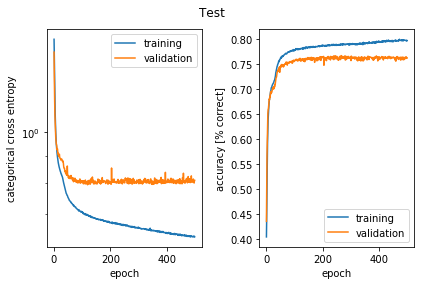

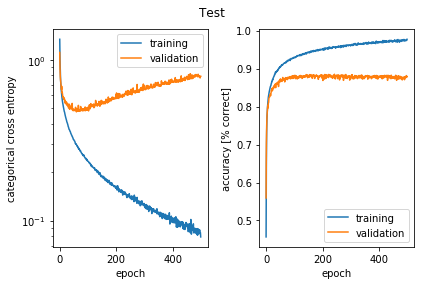

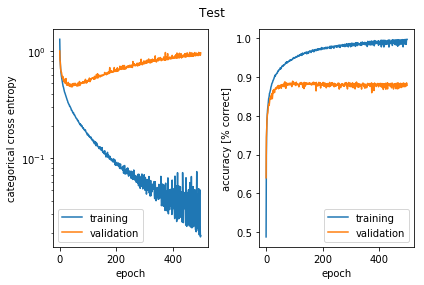

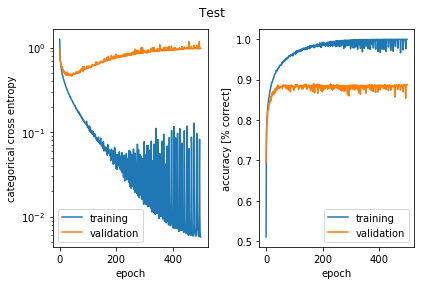

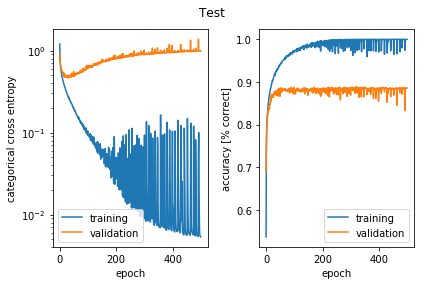

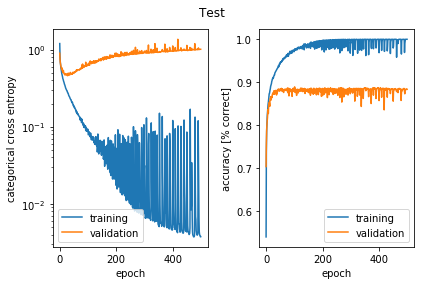

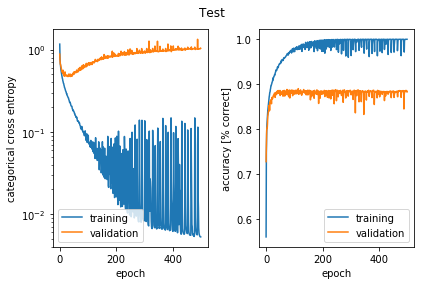

In [111]:
for i in models_history:
    plot_history(i, "Test")

## Exercise 5: Comparison to deep models

### Description

Instead of choosing one hidden layer (with many neurons) you experiment here with multiple hidden layers (each with not so many neurons).

1. Fit models with 2, 3 and 4 hidden layers with approximately the same number of parameters as a network with one hidden layer of 100 neurons. Hint: Calculate the number of parameters in a network with input dimensionality N_in, K hidden layers with N_h units, one output layer with N_out dimensions and solve for N_h. Confirm you result with the keras method model.summary().
2. Run each model multiple times with different initial conditions and plot summary statistics of the best validation loss and accuracy versus the number of hidden layers.

### Solution

## Exercise 6: Tricks (regularization, batch normalization, dropout)

### Description

Overfitting can also be counteracted with regularization and dropout. Batch normalization is supposed to mainly decrease convergence time.

1. Try to improve the best validation scores of the model with 1 layer and 100 hidden neurons and the model with 4 hidden layers. Experiment with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases.
2. After you have found good settings, plot for both models the learning curves of the naive model you fitted in the previous exercises together with the learning curves of the current version.
3. For proper comparison, plot also the learning curves of the two current models in a third figure.

### Solution

## Exercise 7: Convolutional networks

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with the parameters and fit it. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_cnn](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).
2. Plot the learning curves of the convolutional neural network together with the so far best performing model.

## Solution